# Natural Language Processing 2: Speech Recognition

Speech recognition consists primarily of two steps: feature extraction and feature classification.  Feature extraction involves denoising, normalizing, and extracting "features," which in this case is a window of the audio that we presume to be a single word.  Note that we must find these features computationally, so we will use a bit of linear algebra to do this.  Then, feature classification involves passing those features through a trained machine learning classifier to map each feature to its most likely word.  This is typically done using Hidden Markov Models or a combination of HMMs and neural networks for speech classification.  Today, we will be going over feature extraction and then passing the results of that to a pre-trained classifier from Google.  Training a classifier from scratch on speech is not something for the faint of heart or those without access to major computing and database resources.

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
from scipy import stats
%matplotlib inline

In [16]:
# Get a sample of the audio file and its signal
freq_sampling, audio_signal = wavfile.read('../data/cutafew.wav')

print('\nSignal shape:', audio_signal.shape)
print('Signal Datatype:', audio_signal.dtype)
print('Signal duration:', round(audio_signal.shape[0] / float(freq_sampling), 2), 'seconds')



Signal shape: (88511,)
Signal Datatype: int16
Signal duration: 8.03 seconds


In [20]:
# Normalize the audio signal to [-1, 1] floating point prior to transformation for stability reasons
print('Raw Min and Max Values: {}'.format(stats.describe(audio_signal)[1]))

norm_signal = audio_signal / np.max(abs(audio_signal))
print('Normalized Min and Max Values: {}'.format(stats.describe(norm_signal)[1]))

Raw Min and Max Values: (-32768, 32512)
Normalized Min and Max Values: (-1.0078740157480315, 1.0)


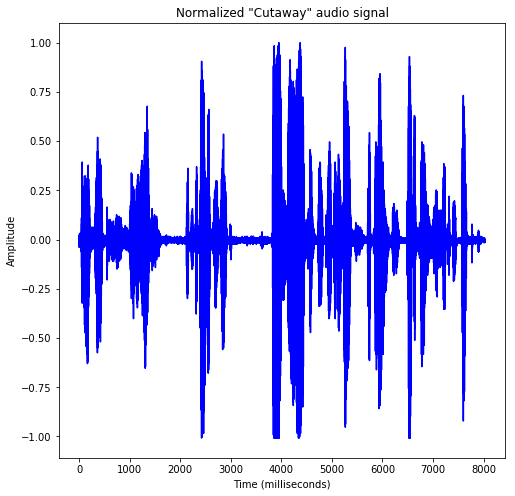

In [27]:
# Visualize the audio signal
time_axis = 1000 * np.arange(0, len(norm_signal), 1) / float(freq_sampling)

# Normalized
plt.figure(figsize=(8,8))
plt.plot(time_axis, norm_signal, color='blue')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.title('Normalized \"Cutaway\" audio signal')
plt.show()

## Spectral Transforms

"Wave-like" data visualized over time can be thought of as a combination of different amplitudes and frequencies all summed on top of one another.  For example, take the figures below (Credit: Paul Balzer).  The green frequency is a summation of the black and red frequencies, however we are truly interested in the black and red frequencies, since they are the main explanatory components of the resulting wave.  To recover these frequencies, we can use spectral transformations.  Principal components is one such linear transformation, however for waves we typically use the Fourier transform, since it was created for oscillatory data.  If you're interested in understanding what is happening with basis transformations in linear algebra, I highly recommend Michael Kirby's Geometric Data Analysis course through Mathematics (some linear algebra background required).

![Signal](signal.png)

![FFT](FFT.gif)

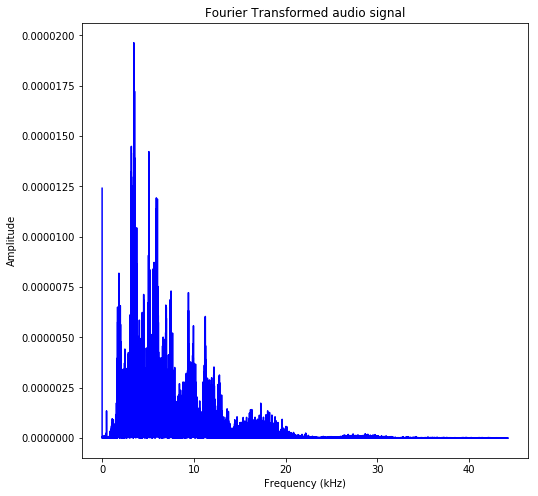

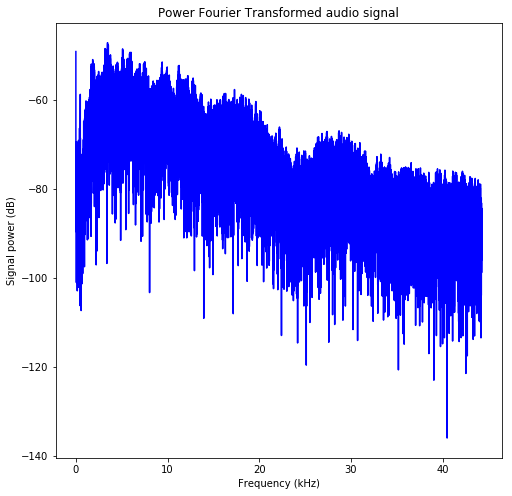

In [41]:
# Perform the Fast Fourier Transform on the normalized signal
signal_len = len(norm_signal)
half_signal_len = np.ceil((signal_len + 1) / 2.0).astype(np.int)
signal_fft = np.fft.fft(norm_signal)

# The resulting transform is symmetric about it's center, so we can just use the first half.
# Due to the nature of frequency space data, we also need to normalize to a unit sum and square the data.
signal_fft = (abs(signal_fft[0:half_signal_len]) / signal_len)**2


# To be honest, I'm not sure what this step is for, but I imagine it has something to do with
# properties of the Fourier transform depending on if the length of the signal array is 
# even or odd.  I think the FFT pads odd-length arrays with 0s for ease of computation, so 
# the final value in an odd FFT result is non-sensical.  I'm not sure about the multiplier of 2.
if signal_len % 2:
   signal_fft[1:len(signal_fft)] *= 2
else:
   signal_fft[1:signal_fft-1] *= 2

# Transform to power-space in order to look at the dB contributions of each frequency component
pow_signal = 10 * np.log10(signal_fft)

plt.figure(figsize=(8,8))
plt.plot(np.arange(0, len(signal_fft)) / 1000, signal_fft, color='blue')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transformed audio signal')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(np.arange(0, len(signal_fft)) / 1000, pow_signal, color='blue')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Signal power (dB)')
plt.title('Power Fourier Transformed audio signal')
plt.show()



## Filtering components using the FFT

The FFT will be important in feature classification, however we could also do preprocessing by removing components that don't contribute more than a certain percent to the overall amplitude in Fourier space.  I will show a few examples of how this affects the original sound file.  A nice attribute of basis transformations is that they are reversible (they are a map from one space to another), so we can operate in Fourier space then convert back to time-space without loss of information.

In [108]:
def fourier_lowpass_filter(raw_data, percent_low_pass):
    # Get FFT
    fft = np.fft.fft(raw_data)
    
    # Get the percent contributions
    percent_fft = abs(fft) / sum(abs(fft))
    
    #print(np.percentile(percent_fft, percent_low_pass))
    quant = np.percentile(percent_fft, percent_low_pass)
    # Set frequencies to zero if they don't meet the low-pass threshold
    filtered_fft = np.array([fft[i] if percent_fft[i] > quant else 0 for i in range(1, len(fft)) ])
    
    # Reverse the FFT
    return np.fft.ifft(filtered_fft)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [109]:
# Original file
Audio(norm_signal, rate=11840)

In [200]:
# Low-pass 1% filter
filtered1 = fourier_lowpass_filter(norm_signal, 1)
Audio(filtered1, rate=11840)

In [202]:
# Low-pass 5% filter
filtered5 = fourier_lowpass_filter(norm_signal, 5)
Audio(filtered5, rate=11840)

In [204]:
# Low-pass 25% filter
filtered25 = fourier_lowpass_filter(norm_signal, 25)
Audio(filtered25, rate=11840)

In [206]:
# Low-pass 50% filter
filtered50 = fourier_lowpass_filter(norm_signal, 50)
Audio(filtered50, rate=11840)

In [208]:
# Low-pass 75% filter
filtered75 = fourier_lowpass_filter(norm_signal, 75)
Audio(filtered75, rate=11840)

In [210]:
# Low-pass 90% filter
filtered90 = fourier_lowpass_filter(norm_signal, 90)
Audio(filtered90, rate=11840)

Note that the Fourier transformation, like Principal Components Analysis (also called the Singular Value Decomposition or Karhunen-Loeve transform) preserve the major components of the data first.  So even with 90% of the lesser frequencies removed from the above sound byte, we can still make out what is being said.  This is what is meant by stating that ordination will give you the major effects of the data and that small changes to lesser components won't change the outcome in ordination space.  Pretty neat.

## Speech classification with Google API

The actual process of speech classification also utilizes the Fourier space, however features are extracted according to very small windows of time, those small sound bytes are mapped to the standard musical scale (mel scale), and then a sequence of those musical notes is run through a machine learning sequence classifier like a Hidden Markov Model.  Here is a Wikipedia summary of the process, which is called Mel-frequency cepstral coefficient extraction (MFCC):

MFCCs are commonly derived as follows:

 - Take the Fourier transform of (a windowed excerpt of) a signal.
 - Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
 - Take the logs of the powers at each of the mel frequencies.
 - Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
 - The MFCCs are the amplitudes of the resulting spectrum.

Additionally, we can use a technique for feature extraction called "Filterbank features," which uses a series of band-pass filters very similar to what we just did with the Fourier transform, only a little more complex.  We will try both feature extraction methods out.

In [162]:
from python_speech_features import mfcc, logfbank

# MFCC feature extraction
features_mfcc = mfcc(audio_signal, freq_sampling)

print('\nMFCC:\nNumber of windows =', features_mfcc.shape[0])
print('Length of each feature =', features_mfcc.shape[1])


MFCC:
Number of windows = 804
Length of each feature = 13


Text(0.5, 1.05, 'MFCC')

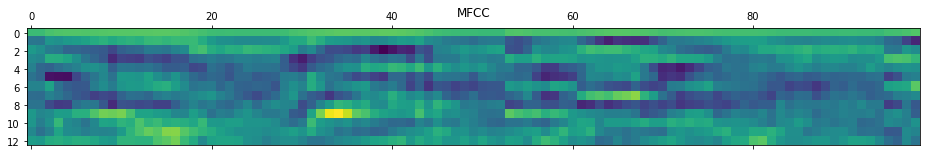

In [163]:
# Display amplitude of first 100 features
t_features_mfcc = features_mfcc.T
plt.matshow(t_features_mfcc[:, 1:100])
plt.title('MFCC')

In [135]:
# Filterbank feature extraction
filterbank_features = logfbank(audio_signal, freq_sampling)
print('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print('Length of each feature =', filterbank_features.shape[1])



Filter bank:
Number of windows = 804
Length of each feature = 26


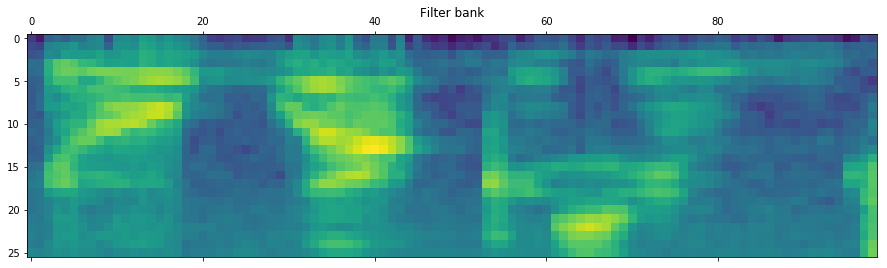

In [136]:
# Display amplitudes of first 100 features
t_filterbank_features = filterbank_features.T
plt.matshow(t_filterbank_features[:, 1:100])
plt.title('Filter bank')
plt.show()

In [174]:
import speech_recognition as sr

# From file
recording = sr.Recognizer()
with sr.AudioFile('../data/cutafew.wav') as source:
    audio = recording.record(source)

type(audio)

speech_recognition.AudioData

In [179]:
# Requires pocketsphinx package in python through pip
# Standard audio
recording.recognize_sphinx(audio)

"you were pacing genius it's quality work and there are seven to one another's that's all just got a few when the beeper"

In [193]:
# From data
source2 = sr.AudioData(audio_signal, sample_rate=11025, sample_width=2)
recording.recognize_sphinx(source2)

"you were pacing genius it's quality work and there are seven to one another's that's all just got a few when the beeper"

In [211]:
# Undo the transformations from the normalization for the fourier low-pass filtered data
un_norm_signal1 = np.array(filtered1 * np.max(abs(audio_signal)), dtype=np.int16)
un_norm_signal5 = np.array(filtered5 * np.max(abs(audio_signal)), dtype=np.int16)
un_norm_signal25 = np.array(filtered25 * np.max(abs(audio_signal)), dtype=np.int16)
un_norm_signal50 = np.array(filtered50 * np.max(abs(audio_signal)), dtype=np.int16)
un_norm_signal75 = np.array(filtered75 * np.max(abs(audio_signal)), dtype=np.int16)
un_norm_signal90 = np.array(filtered90 * np.max(abs(audio_signal)), dtype=np.int16)

In [213]:
# See if this improves Sphinx recognition
print('1% FFT Low-pass Filter:')
source4 = sr.AudioData(un_norm_signal1, sample_rate=11025, sample_width=2)
print(recording.recognize_sphinx(source4))
print('\n')

print('5% FFT Low-pass Filter:')
source4 = sr.AudioData(un_norm_signal5, sample_rate=11025, sample_width=2)
print(recording.recognize_sphinx(source4))
print('\n')

print('25% FFT Low-pass Filter:')
source4 = sr.AudioData(un_norm_signal25, sample_rate=11025, sample_width=2)
print(recording.recognize_sphinx(source4))
print('\n')

print('50% FFT Low-pass Filter:')
source4 = sr.AudioData(un_norm_signal50, sample_rate=11025, sample_width=2)
print(recording.recognize_sphinx(source4))
print('\n')

print('75% FFT Low-pass Filter:')
source4 = sr.AudioData(un_norm_signal75, sample_rate=11025, sample_width=2)
print(recording.recognize_sphinx(source4))
print('\n')

print('90% FFT Low-pass Filter:')
source4 = sr.AudioData(un_norm_signal90, sample_rate=11025, sample_width=2)
print(recording.recognize_sphinx(source4))
print('\n')

1% FFT Low-pass Filter:
go where peace ingenious it's quality work are simply to one another's that's all just got a few one it'll be perfect


5% FFT Low-pass Filter:
go where peace ingenious it's quality work are simply to one another's that's all just got a few one it'll be perfect


25% FFT Low-pass Filter:
go where patients genius it's quality work are simply to one of the call has got a few one of the fed


50% FFT Low-pass Filter:
you were a convenient equality we're out of the government of that all those caught up to one little different


75% FFT Low-pass Filter:
no one in quality of life that the women of all the other two when it


90% FFT Low-pass Filter:
what will


